# Options Data Scraping and Strategy Analysis



The purpose of this notebook is to review webscraping with BeautifulSoup4 and Selenium and to implement the data in options-related trading strategies.


### Contents:
1. Web-scraping the option chain

2. Alternative pricing calculations

3. Defining our strategy class

4. Illustrations/examples

5. Conclusions

6. Future follow-ups

In [1]:
import requests 
import pandas as pd

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

## Webscraping
For this exercise, we will be using the BeautifulSoup and Selenium libraries. Selenium is key so that we can navigate to a website with Javascript and tease out the HTML we are looking for.



The function defined in the next cell will use Selenium to navigate to barchart.com and retrieve option chain data given specified parameter values. Note that to use selenium, we need to download a webdriver that allows for automation of webpage navigation. As I prefer Chrome, I use ChromeDriver, which can be downloaded here (depending on version): https://chromedriver.chromium.org/downloads

In [16]:
def option_chain(ticker, exp_date, volume_screen=0, oi_screen=0, timeout=30):
    """ 
    returns option chain in the form of a dataframe
    ticker: desired underlying ticker as string. "SPY" for example
    exp_date: Desired option chain expiration date. Must be in the format YYYY-mm-dd 
    volume_screen: filter out strikes that have volume below the threshold
    oi_screen: filter out strikes that have open interest below the threshold
    timeout: specifies the period in seconds to wait for webpage response
    """
    chrome_options = Options()
    driver = webdriver.Chrome(options=chrome_options) 
    try:
        url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-m&moneyness=allRows" # for IVP
        driver.get(url)
        
        # check for webpage response
        try:
            element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
            my_elem = WebDriverWait(driver, timeout).until(element_present)
        except TimeoutException:
            print("Loading took too much time!")

        # get the underlying HTML 
        dom = driver.page_source
        soup = BeautifulSoup(dom, "lxml")
        
        # URL requires monthly/weekly specification. Try monthly first, then weekly.
        first_string = soup.find_all("div", {"class": "middleware-wrapper"})[0].get_text().replace("\n", "")
        data_string = first_string.replace(" ", "").replace("N/A", "")  # strip of unnecessary chars
        if data_string[-8:] == "expired.":  
            print(f"Could not find monthly for {ticker} on {exp_date}. Trying Weekly.")
            url = f"https://www.barchart.com/etfs-funds/quotes/{ticker}/options?expiration={exp_date}-w&moneyness=allRows" 
            driver.get(url)
            try:
                element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
                my_elem = WebDriverWait(driver, timeout).until(element_present)
            except TimeoutException:
                print("Loading took too much time!")          
                
            dom = driver.page_source
            soup = BeautifulSoup(dom, "lxml")
            
    except Exception as e:
        print(f"Trouble gathering data -- {e}")
        driver.quit()
        
    driver.quit()
    
    # Use BeautifulSoup to scrape data
    tables = soup.find_all("div", {"class": "barchart-content-block"})
    cols = ["strike", "moneyness", "bid", "midpoint", "ask", "last", "change", "pct_chg", "volume", "oi", 
            "vol/oi", "iv", "date", "links"]
    chains = []
    for i in tables:
        option_type = i.find_all("div", {"class": "block-title joined"})[0].get_text().replace("\n","")
        td = i.find_all("td")
        table_data = [t.get_text().replace("\n", "").replace("%", "").replace("+", "").replace("-","") for t in td]
        assert(len(table_data) % len(cols) == 0), "Trouble scraping data"

        table_data = [table_data[r:r+len(cols)] for r in range(0, len(table_data), len(cols))]
        df = pd.DataFrame(data=table_data, columns=cols).drop(["change", "pct_chg", "vol/oi", "date", "links"], axis=1)
        df["type"] = option_type
        chains.append(df)
    
    try:
        option_chain = pd.concat([df for df in chains], axis=0)
    except ValueError as e:
        print(f"No data from {url}")
        option_chain = None
        
    # Preprocess our data here
    option_chain["oi"] = option_chain["oi"].str.replace(",", "")
    option_chain["volume"] = option_chain["volume"].str.replace(",", "")
    for c in option_chain.columns:
        if c != "type":
            option_chain[c] = pd.to_numeric(option_chain[c], errors="coerce")
        
    option_chain = option_chain.dropna().reset_index(drop=True)
    option_chain["iv"] /= 100
    option_chain["moneyness"] /= 100  

    # Separate calls from puts and returns
    calls = option_chain.loc[option_chain["type"] == "Calls"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]
    puts = option_chain.loc[option_chain["type"] == "Puts"][["strike", "bid", "midpoint", "ask", "iv", "volume", "oi"]]

    calls = calls.loc[(calls["volume"] >= volume_screen) & (calls["oi"] >= oi_screen)]
    puts = puts.loc[(puts["volume"] >= volume_screen) & (puts["oi"] >= oi_screen)]

    return calls, puts

Now let's run the function, look at the call option chain


In [18]:
calls, puts = option_chain(ticker="QQQ", exp_date="2021-07-16", volume_screen=10)
calls.head()

,strike,bid,midpoint,ask,iv,volume,oi
1,170.0,163.06,163.18,163.30,0.0000,10.0,10.0
17,217.0,116.05,116.18,116.30,0.0000,20.0,20.0
21,221.0,112.22,112.35,112.47,0.0000,32.0,32.0
52,252.0,81.26,81.36,81.46,0.0000,16.0,7.0
60,260.0,73.52,73.60,73.68,0.3424,23.0,42.0


We've collected the option chains for calls and puts for the specified ticker/date. Now we have our data! Next steps involve building out strategies, calculating key metrics, and additional analysis.



In [19]:
import scipy.stats as stats

import numpy as np
from collections import defaultdict
import datetime as dt
import re
import yahoo_fin.options as options
import yfinance as yf
import multiprocessing

import math
import os
from scipy.stats import norm
import scipy.stats
from random import gauss
from yahoo_fin import stock_info as si
from scipy.interpolate import interp1d

import matplotlib.pyplot as plt
import seaborn as sns



We will start by creating some functions that will help make slight preprocessing/calcuation adjustments to data that will help inform us for possible positions. The two blocks of codes (along with notes) below can be thought of as belonging to one of two subsets: the first defines preprocessing functions that will give us data required for our analysis based on the option chain we just gathered. The second block is a set of option price calculations based on different pricing methods. Prices will differ slightly across methods and certain methods are preferable in certain circumstances. However, those functions are mostly illustrative/sanity-checking measures.



In [28]:
def calc_greeks(s, k, sigma, t, price, r, q, payoff="calls"):
    """ 
    Calculate greeks for a single option strike.
    s: spot price
    k: strike price
    sigma: volatility
    t: time to maturity as a portion of a full year
    price: option price
    r: risk free rate
    q: dividend yield
    returns: dictionary of greeks for the option 
    """
    greeks = {}
    d1 = (np.log(s/k) + (r + sigma**2/2) * t) / (sigma*np.sqrt(t))
    d2 = (np.log(s/k) + (r - sigma**2/2) * t) / (sigma*np.sqrt(t))
    norm_cdf = (1 / np.sqrt(2*np.pi)) * np.exp(-d1**2 / 2)

    if payoff == "call":
        greeks["delta"] = np.exp(-q*t) * norm.cdf(d1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*snp.qrt(t)*norm_cdf) - r*k*np.exp(-r*t)*norm.cdf(d2) + q*s*np.exp(-q*t)*norm.cdf(d1)) / 365.242199 
        greeks["rho"] = (k*t*np.exp(-r*t)*norm.cdf(d2)) / 100

    elif payoff == "put":
        greeks["delta"] = np.exp(-q*t) * (norm.cdf(d1) - 1)
        greeks["theta"] = (-(s*sigma*np.exp(-q*t) / 2*np.sqrt(t)*norm_cdf) + r*k*np.exp(-r*t)*norm.cdf(-d2) - q*s*np.exp(-q*t)*norm.cdf(-d1)) / 365.242199 
        greeks["rho"] = -(k*t*np.exp(-r*t)*norm.cdf(-d2)) / 100

    greeks["gamma"] = np.exp(-q*t) / (s * sigma * np.sqrt(t)) * norm_cdf
    greeks["vega"] = (s*np.exp(-q*t)*np.sqrt(t) * norm_cdf) / 100

    return greeks


def ticker_history(ticker, window=126, days_offset=756):
    """ 
    Uses yahoo finance to calulcate returns and volatility
    window: length of window for rolling volatility calculations. Longer window leads to more inclusive and smoother vol.
    days_offset: amount of days to pull into dataframe, going back from today
    returns: dataframe with calculated return/vol data for entire date range
    """
    ticker_obj = yf.Ticker(ticker)
    start = dt.datetime.strftime(dt.datetime.today() - dt.timedelta(days_offset), "%Y-%m-%d")
    end = dt.datetime.strftime(dt.datetime.today(), "%Y-%m-%d") 
 
    data = ticker_obj.history(period='1d', start=start, end=end)
    data["returns"] = data["Close"].pct_change()
    data["log_returns"] = np.log(data["Close"] / data["Close"].shift(1))
    data["rolling_std"] = data["log_returns"].rolling(window).std()
    data["annualized_vol"] = data["rolling_std"] * math.sqrt(252) 

    return data.dropna()


def ticker_momentum(ticker, window=21):
    """ 
    Calculate momentum for underlying ticker and return price history.
    window: window for calculating momentum. Defaults to momentum over the past month.
    returns: scalar momentum value
    """
    ticker_obj = yf.Ticker(ticker)
    data = ticker_obj.history(period='1d', start='2019-1-1')
    data[f"sma_{window}"] = data["Close"].rolling(window=window).mean() # get 10 month SMA
    data["momentum"] = data["Close"] / data[f"sma_{window}"] - 1  # current vs. 10m SMA
    
    return data.iloc[-1]["momentum"]

For more information on option greeks:
   

In the next block of code, we will define our functions for theoretical price calculations. Note that our option chain data will give us pricing data, so these prices are not a be-all end-all. Rather, I like to use them for comparison purposes and alternative entry points. Strictly speaking, these are not necessary for determining trade entry if you are willing to enter at the midpoint. However, for less liquid securities, that is often sub-optimal.

In [37]:
def mc_asset_price(s, sigma, r, t, q, n_paths=500000, plot=False):
    """
    use monte carlo simulation with n_paths to estimate price of an option
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    """
    w = stats.norm.rvs( (r-0.5*sigma**2)*t , np.sqrt(t)*sigma, n_paths)
    future_prices = s * np.exp(w)

    future_prices = np.array(future_prices)
    skew = stats.skew(future_prices)
    
    # TODO: bring out of this function and add breakevens in red
    if plot:
        fig, ax = plt.subplots(figsize=(9,7))
        sns.set_style("darkgrid", {"axes.facecolor": ".95"});
        sns.set_context("talk")
        plt.axvline(x=s, c="g", ls="--")
        plt.xlabel("Underlying Price")
        sns.kdeplot(future_prices, ax=ax);
        print(f"Skew: {skew:.2f}\nMean: {np.mean(future_prices):.2f}\nMin: {np.min(future_prices):.2f}\nMax: {np.max(future_prices):.2f}")
    
    return future_prices


def mc_option_price(s, k, sigma, r, t, q, n_paths=100000, payoff="call"):
    """
    Use monte carlo simulation to estimate price of an option
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    returns: scalar option price
    """
    payoffs = []
    for i in range(n_paths):  
        s_T = generate_asset_price(s, sigma, r, t, q)
        if payoff == "call":
            payoff = max(0, s_T - k)
        else:
            payoff = max(0, k - s_T)

        payoffs.append(payoff)

    discount_factor = math.exp(-r-q*t)
    option_price = discount_factor * (sum(payoffs) / float(n_paths))

    return option_price

def binomial_option_price(s, k, sigma, t, r, q, n=10000, payoff="call"):
    """ 
    Use binomial option pricing method to return option value 
    s: current spot price
    k: strike price
    sigma: volatility
    r: risk-free rate
    t: time-to-expiration (in years)
    q: annualized dividend yield
    returns: scalar option price
    """
    d_t = t / n  # where t is portion of year
    u = np.exp(sigma * math.sqrt(d_t))
    d = 1.0 / u

    v = np.zeros(n+1)  # initialize price vector
    s_t = np.array([(s * u**j * d**(n-j)) for j in range(n+1)])  # build out final nodes

    # compounded risk-free return is = a = np.exp(r * dt)
    p = (np.exp((r - q)*d_t) - d) / (u - d)  # risk-neutral up probability
    q = 1.0 - p  # risk-neutral down probability

    # Account for potential exercision
    if payoff == "call":
        v[:] = np.maximum(s_t - k, 0.0)
    elif payoff == "put":
        v[:] = np.maximum(k - s_t, 0.0)
        
    # recursively find value at non-end nodes and return price
    for i in range(n-1, -1, -1):  
         v[:-1] = (p*v[1:] + q*v[:-1]) * math.exp(-r*d_t)   

    return v[0]

For more info on pricing methods used above:
- <b>Monte Carlo</b>: Wikipedia https://medium.com/swlh/option-pricing-using-monte-carlo-simulations-41d9e4ad95f6


- <b>Binomial</b>: https://www.investopedia.com/terms/b/binomialoptionpricing.asp

### Strategy Class

Finally, we will create our strategy class. I assume that the reader has some fundamental knowledge regarding option payouts, so I will keep any explanations brief so that I avoid going into too much depth.

In [43]:
#TODO: Expected move, 
class OptionStrategy:
    """
    Class that simulates a variety of trading strategies and outputs a summarized analysis and the option chains
    exp_date: expirate date of desired option. Note that this needs to be a valid date
    n_contracts: number of contracts to be traded
    commissions: commissions per contract
    """
    def __init__(self, ticker, exp_date, vol_window=21, n_contracts=1, commissions=0.6):
        today = dt.datetime.today()
        dte = (dt.datetime.strptime(exp_date, "%Y-%m-%d") - today).days + 1
        dpm = 365.25/12
        self.t = dte / 365.25  # get fraction of year
        print(f"{dte} days until expiration.")
        
        self.ticker = ticker
        self.exp_date = exp_date
        self.n_contracts = n_contracts
        self.total_commissions= commissions * n_contracts
        
        # use pre-defined functions/methods to get the rest of the necessary inputs
        self.r = self._risk_free(self.t*365.25/dpm)  # get interpolated risk free rate (input is # of months)
        self.hist = ticker_history(self.ticker, window=vol_window)
        self.sigma = self.hist.iloc[-1]["annualized_vol"]
        
        # get dividend yield (only if a dividend occurs between now and exercise date)
        self._get_div()
        
        # get option chains upon instantiation
        self.calls, self.puts = option_chain(self.ticker, self.exp_date)

    def iron_condor(self, short_delta=.2, spread=5, n_paths=100000, plot=False):
        """ 
        Return chains and summary for covered iron condor strategy 
        short_delta: deltas at which we will place short call and put
        spread: width of condor wing. If <1, represents a delta spread rather than a dollar spread
        n_paths: number of paths for MC simulation
        plot: Whether we want a basic visualization as part of the summary
        """        
        total_commissions = self.total_commissions * 4
        spot = si.get_live_price(self.ticker)
        
        # Calculate delta for each option
        calls = self.calls
        puts = self.puts
        calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + 
                                             (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), 
                                              axis=1)
        calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))

        puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                           (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), 
                                            axis=1)
        puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
        calls["delta_diff"] = abs(calls["delta"] - short_delta)
        puts["delta_diff"] = abs(puts["delta"] + short_delta)

        short_call =  calls.loc[calls["delta_diff"] == calls["delta_diff"].min()].iloc[-1]
        short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
        short_call_strike = float(short_call["strike"])
        short_put_strike = float(short_put["strike"])
        
        calls["spot_diff"] = abs(calls["strike"] - spot)
        atm_strike = calls.loc[calls["spot_diff"] == calls["spot_diff"].min()].iloc[-1]
        
        print(f"Summary for spot of {spot} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")
        
        # use dollar spread to find long call and put strikes
        if spread >= 1:
            calls["long_diff"] = abs(calls["strike"] - (short_call_strike + spread))
            puts["long_diff"] = abs(puts["strike"] - (short_put_strike - spread))
            long_call = calls.loc[calls["long_diff"] == calls["long_diff"].min()].iloc[-1]
            long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
            
        # use delta spread to find long call and put strikes
        else:
            calls["long_diff"] = abs(calls["delta"] - short_delta + delta_spread)  # e.g. trying to find 16 and 5 deltas
            puts["long_diff"] = abs(puts["delta"] + short_delta - delta_spread)
            long_call = calls.loc[calls["long_diff"] == calls["long_diff"].min()].iloc[-1]
            long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
      
        long_put_strike = float(long_put["strike"])
        long_call_strike = float(long_call["strike"])

        upper_dollars_otm = round(spot - short_call["strike"], 2)
        lower_dollars_otm = round(short_put["strike"] - spot, 2)
        
        # Calculate price based on BS or BOPM
        theoretical_long_put = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        theoretical_short_put = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_short_call = self._get_price(k=short_call_strike, iv=float(short_call["iv"]), payoff="call")
        theoretical_long_call = self._get_price(k=long_call_strike, iv=float(long_call["iv"]), payoff="call")
        net_theoretical = (theoretical_short_put - theoretical_long_put) + (theoretical_short_call - theoretical_long_call)

        # find spreads and mid points
        call_spread = long_call_strike - short_call_strike
        put_spread = short_put_strike - long_put_strike
        credit = float(short_call["midpoint"]) + float(short_put["midpoint"])
        debit = float(long_call["midpoint"]) + float(long_put["midpoint"])
        net_credit = credit - debit - total_commissions/100  # use for price entry
        spread = max(call_spread, put_spread)

        # calculate gain, loss, credit pct of width
        max_gain = (net_credit*100*self.n_contracts)
        max_loss = 100*self.n_contracts*(max(call_spread, put_spread)) - 100*net_credit
        
        # calculate breakevens
        upper_breakeven = short_call_strike + net_credit
        lower_breakeven = short_put_strike - net_credit
        upper_fifty = short_call_strike + net_credit / 2
        lower_fifty = short_put_strike - net_credit / 2
        
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where((future_prices>lower_breakeven) & (future_prices<upper_breakeven), 1, 0)
#         avg_profit = np.mean(fo)
        fifty_percents = np.where((future_prices[profits==1]>lower_fifty) & (future_prices[profits==1]<upper_fifty), 1, 0)
        pop = float(np.sum(profits) / profits.shape)    
        net_short_delta = -short_put["delta"] + short_call["delta"]
        market_order_net = (short_call["bid"] + short_put["bid"]) - (long_call["ask"] + long_put["ask"])    
        credit_to_bpr = 100*max_gain / max_loss
        
        # Print summary
        print(f"Long Put strike is: {long_put_strike}\nShort Put strike is: {short_put_strike}")
        print(f"Short Call strike is: {short_call_strike}\nLong Call strike is: {long_call_strike}\n------------------------------------------------------\n")
        print(f"Credit/BPR: {credit_to_bpr:.2f}%")
        print(f"Limit Order based on midpoint is at: {credit-debit:.2f}")
        print(f"Limit Order based on theoretical price is: {net_theoretical:.2f}")
        print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
        print(f"Upper breakeven is: {upper_breakeven}\nLower breakeven is: {lower_breakeven}")
        print(f"Percent of Profit is: {pop*100:.2f}%")
        print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
            
        if plot:
            sns.set_style("darkgrid", {"axes.facecolor": ".95"});
            sns.set_context("talk")

            tick_width = math.ceil(spot / 100)
            x_ticks = sorted([spot - tick_width*i for i in range(15)]+[spot + tick_width*i for i in range(15)])
            x_ticks = np.array(x_ticks)
            between_shorts = np.where((x_ticks<short_call_strike) & (x_ticks>short_put_strike), net_credit, 0)
            between_calls = np.where((x_ticks>short_call_strike) & (x_ticks<long_call_strike), 
                                     net_credit-(x_ticks-short_call_strike), 0)
            between_puts = np.where((x_ticks<short_put_strike) & (x_ticks>long_put_strike), 
                                     net_credit-(short_put_strike-x_ticks), 0)
            beyond_bounds = np.where((x_ticks<=long_put_strike) | (x_ticks>=long_call_strike), -max_loss/100, 0)

            pl = between_shorts + between_calls + between_puts + beyond_bounds
            plot_df = pd.DataFrame(data=zip(x_ticks, pl), columns=["Spot Price", "P&L"])

            fig, ax = plt.subplots(figsize=(8,4))
            ax.plot(x_ticks, [0]*len(x_ticks), '--', color='r');
            sns.lineplot(data=plot_df, x="Spot Price", y="P&L", color="green");

        return calls, puts, credit_to_bpr
    
    def covered_call(self, short_delta=.3, n_paths=100000):
        """ 
        Return chain and summary for covered call strategy 
        short_delta: delta at which we will place short call
        n_paths: number of paths for MC simulation
        """
        spot = round(si.get_live_price(self.ticker),2)

        # TODO: Add theta vega calcs, summary
        # setup greeks
        calls = self.calls
        calls["d1"] = calls.apply(lambda x: (math.log(spot / x["strike"]) + \
                                             (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
        calls["d2"] = calls.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
        calls["delta"] = calls["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x))

        calls["delta_diff"] = abs(calls["delta"] - short_delta)
        calls["credit_pct_of_underlying"] = calls["midpoint"] / spot * 100
        short_call = calls.loc[calls["delta_diff"] == calls["delta_diff"].min()]
        short_call_strike = short_call["strike"]
        
        theoretical_short_call = self._get_price(k=float(short_call_strike), iv=float(short_call["iv"]), payoff="call")
        credit = max(float(short_call["midpoint"]), theoretical_short_call)
        gains_bound = float(credit + short_call_strike)

        # MC statistics
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(gains_bound>future_prices, 1, 0)  # if credit + strike exceeds future spot
        percent_beat_spot = np.sum(profits) / profits.shape[0]

        # Print summary
        print(f"Covered Call Summary for spot of {spot:.2f}:\n------------------------------------------------------\n ")
        print(f"Short call at: {float(short_call_strike)}")
        print(f"Limit Order based on theoretical price is: {theoretical_short_call:.2f}")
        print(f"Limit Order based on midpoint is: {float(short_call['midpoint']):.2f}")
        print(f"Premium pct of underlying for {spot} delta call: {round(float(short_call['credit_pct_of_underlying']),3)}%")
        print(f"Gains for underlying capped at: {gains_bound}")  # ideally premium of 30 delta at 30 dte is ~1%
        print(f"Expected % of time covered call beats spot: {percent_beat_spot*100}%")

        return calls
    
    def debit_spread(self, long_delta=.4, n_paths=100000, payoff="put"):
        """ 
        Return chain and summary for debit spread strategy 
        long_delta: delta at which we will place long call or put
        n_paths: number of paths for MC simulation
        """
        spot = si.get_live_price(self.ticker)
        puts = self.puts
        calls = self.calls
        
        if payoff == "put":
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

            puts["delta_diff"] = abs(puts["delta"] + long_delta)
            short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            short_put_strike = float(short_put["strike"])
            print(f"Summary for spot of {spot:.2f} with strikes at {long_delta*100} delta:\n------------------------------------------------------\n")

            short_spot_diff = spot - short_put_strike
            puts["strike_diff"] = abs(puts["strike"] - (atm_strike["strike"] + short_spot_diff))
            long_put = puts.loc[puts["strike_diff"] == puts["strike_diff"].min()].iloc[-1]
            long_put_strike = float(long_put["strike"])
            long_spot_diff = long_put_strike - spot

        # TODO:
        if payoff == "call": 
            raise NotImplementedError
            
        # Calculate price based on BS or BOPM
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        net_theoretical_debit = theoretical_long - theoretical_short

        # instead of a debit, we are 'paying' net_cred - moneyness (so we have extrinisic value on entry)
        spread = long_put_strike - short_put_strike
        net_debit = long_put["midpoint"] - short_put["midpoint"] + total_commissions/100
        net_ext_value = short_put["midpoint"] - (long_put["midpoint"] - long_spot_diff) 
        
        # Get greeks for summary
        short_greeks = calc_greeks(spot, short_put_strike, short_put["iv"], self.sigma, short_put["midpoint"], self.r, self.q, "put")
        long_greeks = calc_greeks(spot, long_put_strike, long_put["iv"], self.sigma, long_put["midpoint"], self.r, self.q, "put")
        net_theta = long_greeks["theta"] - short_greeks["theta"]
        net_vega = long_greeks["vega"] - short_greeks["vega"]
        net_delta = long_greeks["delta"] - short_greeks["delta"]
                                  
        # calculate gain, loss, credit pct of width
        max_gain = ((spread-net_debit) * 100 * self.n_contracts)
        max_loss = 100*self.n_contracts*(net_debit) + total_commissions

        upper_breakeven = spot + net_ext_value - total_commissions/100
        lower_fifty = spot - max_gain / 200

        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(future_prices<upper_breakeven, 1, 0)
        pop = float(np.sum(profits) / profits.shape)    

        fifty_percents = np.where(future_prices[profits==1]<=lower_fifty, 1, 0)  # conditional on profit? or is it immediate take?
        open_interest = [short_put["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_put["volume"]]
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")
                  
        # Print summary
        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Net extrinsic value/implicit debit: {net_ext_value:.2f}")  
        print(f"Limit Order based on midpoint is: {net_debit:.2f}")
        print(f"Limit Order based on theoretical price is: {net_theoretical_debit:.2f}")
        print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
        print(f"Upper breakeven is: {upper_breakeven:.2f}")
        print(f"Percent of Profit is: {pop*100:.2f}%")
        print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
        print(f"Delta on order entry {net_delta:.3f}")
        print(f"Vega on order entry {net_vega:.3f}")
        print(f"Theta on order entry {net_theta:.3f}") 
        print(f"Order Return/Risk: {max_gain/max_loss:.2f}")
            
        return puts, calls
    
    def ratio_spread(self, long_delta=.4, spread=5, long_contracts=1, short_contracts=2, n_paths=100000, payoff="put"):
        """ 
        Return chain and summary for debit spread strategy 
        long_delta: delta at which we will place long call or put
        spread: width of condor wing. If <1, represents a delta spread rather than a dollar spread
        long_contracts: number of contracts we will buy
        short_contracts: number of contracts we will sell
        n_paths: number of paths for MC simulation
        """
        total_commissions = (self.total_commissions / self.n_contracts) * (long_contracts + short_contracts)
        spot = si.get_live_price(self.ticker)
        calls, puts = option_chain(self.ticker, self.exp_date)
        
        if payoff == "put":
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

            puts["delta_diff"] = abs(puts["delta"] + long_delta)
            long_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            long_put_strike = long_put["strike"]
            print(f"Summary for spot of {spot:.2f} with strikes at {long_delta*100} delta:\n------------------------------------------------------\n")

            if spread >= 1:
                puts["strike_diff"] = abs(puts["strike"] - (long_put_strike - spread))
                short_put = puts.loc[puts["strike_diff"] == puts["strike_diff"].min()].iloc[-1]
                short_put_strike = short_put["strike"]
                
            else:
                puts["short_delta_diff"] = abs(puts["delta"] + long_delta - spread)
                short_put = puts.loc[puts["short_delta_diff"] == puts["short_delta_diff"].min()].iloc[-1]
                short_put_strike = short_put["strike"]
                spread = long_put_strike - short_put_strike
                
        # TODO
        elif payoff == "put":
            raise NotImplementedError
        
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff="put")
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff="put")
        net_theoretical_credit = (theoretical_short * short_contracts) - (theoretical_long * long_contracts)
        net_credit = (short_put["midpoint"]*short_contracts)-(long_put["midpoint"]*long_contracts) - total_commissions/100
        
        # Get greeks for summary
        short_greeks = calc_greeks(spot, short_put_strike, short_put["iv"], self.sigma, short_put["midpoint"], self.r, self.q, "put")
        long_greeks = calc_greeks(spot, long_put_strike, long_put["iv"], self.sigma, long_put["midpoint"], self.r, self.q, "put")
        net_theta = (long_greeks["theta"] * long_contracts) - (short_greeks["theta"] * short_contracts)
        net_vega = (long_greeks["vega"] * long_contracts) - (short_greeks["vega"] * short_contracts)
        net_delta = (long_greeks["delta"] * long_contracts) - (short_greeks["delta"] * short_contracts)
                       
        # calculate gain, loss, credit pct of width
        max_gain = ((net_credit+spread) * 100 * long_contracts)  # max loss is undefined
        lower_breakeven = short_put_strike - (max_gain/100) + (total_commissions/100)
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        profits = np.where(future_prices>lower_breakeven, 1, 0)
        pop = float(np.sum(profits) / profits.shape)    
        
        open_interest = [short_put["oi"], long_put["oi"]]
        volumes = [short_put["volume"], long_put["volume"]]
                                              
        if any(open_interest) == 0 or any(volumes) == 0:
            print("WARNING: this trade lacks sufficient liquidity.")

        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Limit Order based on midpoint is: {net_credit:.2f}")
        print(f"Limit Order based on theoretical price is: {net_theoretical_credit:.2f}")
        print(f"Max gain is: {max_gain:.2f}")
        print(f"Lower breakeven is: {lower_breakeven:.2f}")
        print(f"Credit % of spread: {net_credit / spread*100:.2f}%")
        print(f"Percent of Profit is: {pop*100:.2f}%")
        print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
        print(f"Delta on order entry {net_delta:.3f}")
        print(f"Vega on order entry {net_vega:.3f}")
        print(f"Theta on order entry {net_theta:.3f}") 

        return calls, puts
        
    def credit_spread(self, short_delta=.3, spread=5, vix_threshold=40, n_paths=100000, plot=False, payoff="put"):
        """ 
        Return chain and summary for credit spread strategy 
        short_delta: delta at which we will place short call or put
        spread: width of condor wing. If <1, represents a delta spread rather than a dollar spread
        long_contracts: number of contracts we will buy
        short_contracts: number of contracts we will sell
        n_paths: number of paths for MC simulation
        """
        total_commissions = self.total_commissions * 2
        spot = si.get_live_price(self.ticker)
        puts = self.puts
        # Generate option chain
        if payoff == "put":
            puts["d1"] = puts.apply(lambda x: (math.log(spot / x["strike"]) + (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            puts["d2"] = puts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            puts["delta"] = puts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            puts["spot_diff"] = abs(puts["strike"] - spot)
            atm_strike = puts.loc[puts["spot_diff"] == puts["spot_diff"].min()].iloc[-1]

            puts["delta_diff"] = abs(puts["delta"] + short_delta)
            short_put = puts.loc[puts["delta_diff"] == puts["delta_diff"].min()].iloc[-1]
            short_put_strike = short_put["strike"]
            print(f"Summary for spot of {spot:.2f} with strikes at {short_delta*100} delta:\n------------------------------------------------------\n")

            puts["long_diff"] = abs(puts["strike"] - (short_put_strike - spread))
            long_put = puts.loc[puts["long_diff"] == puts["long_diff"].min()].iloc[-1]
            long_put_strike = long_put["strike"]
            lower_dollars_otm = short_put_strike - spot
            
        # TODO
        elif payoff == "call":
            raise NotImplementedError
        
        # Calculate price based on BS or BOPM
        theoretical_short = self._get_price(k=short_put_strike, iv=float(short_put["iv"]), payoff=payoff)
        theoretical_long = self._get_price(k=long_put_strike, iv=float(long_put["iv"]), payoff=payoff)
        net_theoretical = theoretical_short - theoretical_long

        # find spreads and mid points
        spread = short_put_strike - long_put_strike
        net_credit = float(short_put["midpoint"])-float(long_put["midpoint"]) - total_commissions/100

        # calculate gain, loss, credit pct of width
        max_gain = (net_credit * 100 * self.n_contracts)
        max_loss = 100*self.n_contracts*(spread - net_credit) # hopefully ~ 30% of width
        max_loss_gross = 100*self.n_contracts*(spread)
        lower_breakeven = float(short_put["strike"] - net_credit)

        # or is that just a misunderstanding of MC process?
        future_prices = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, plot=False)
        profits = np.where(future_prices>lower_breakeven, 1, 0)

        # get theoretical prices
        sim_short_price = scipy.mean(np.exp(-self.r*self.t) * np.maximum(short_put_strike - future_prices, 0))
        sim_long_price = scipy.mean(np.exp(-self.r*self.t) * np.maximum(long_put_strike - future_prices, 0))
        sim_spread = sim_short_price - sim_long_price

        profit_dollars = np.where(future_prices>lower_breakeven, net_credit, future_prices-lower_breakeven)
        profit_dollars = profit_dollars.clip(-spread, net_credit)

        fifty_percents = np.where(future_prices[profits==1]>lower_fifty, 1, 0)
        pop = float(np.sum(profits) / profits.shape)    
        credit_to_bpr = 100*max_gain / max_loss
        expected_move = spot*atm_strike["iv"]*math.sqrt(self.t)
        
        print(f"Long Put strike is: {long_put['strike']}\nShort Put strike is: {short_put['strike']}")
        print(f"Credit/BPR: {credit_to_bpr:.2f}%")

        if verbose:  # can filter out some of the verbiage if needed
            print(f"Limit Order based on midpoint is: {net_credit:.2f}")
            print(f"Max gain is: {max_gain:.2f}\nMax loss is: {max_loss:.2f}")
            print(f"Lower breakeven is: {lower_breakeven}")
            print(f"Percent of Profit is: {pop*100:.2f}%")
            print(f"Expected P&L: {profit_dollars.mean():.2f}")
            print(f"Historical Annualized Vol: {self.sigma*100:.2f}%")
            print(f"Current underlying momentum is: {current_mom:.3f}\n------------------------------------------------------\n")
            print(f"Limit Order based on theoretical price is: {net_theoretical:.2f}")
            print(f"Limit Order based on monte carlo: {sim_spread:.2f}")
            print(f"Market expected move: {expected_move:.2f}")
            
        # TODO
        if plot: 
            raise NotImplementedError
            
        return puts, credit_to_bpr
    
              
    def diagonal_spread(self, long_exp_date, long_delta=.4, spread=.2, n_paths=100000, payoff="put"):
        """ simulate payoff and summary of long calendar spread. Does not include management potential """
        raise NotImplementedError

        long_calls, long_puts = option_chain(self.ticker, long_exp_date)
        short_calls, short_puts = option_chain(self.ticker, self.exp_date)
        spot = si.get_live_price(self.ticker)
        
        today = dt.datetime.today()
        dte = (dt.datetime.strptime(long_exp_date, "%Y-%m-%d") - today).days

        dpm = 365.25/12
        long_t = dte / 365.25  # get fraction of year
        long_r = self._risk_free(long_t*365.25/dpm)  # get interpolated risk free rate (where input is # of months)

        future_prices_short = mc_asset_price(spot, sigma=self.sigma, r=self.r, t=self.t, q=self.q, n_paths=n_paths)
        future_prices_long = mc_asset_price(spot, sigma=self.sigma, r=long_r, t=long_t, q=self.q, n_paths=n_paths)

        if payoff == "put":
            longs = long_puts
            shorts = short_puts
            longs["d1"] = longs.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
            longs["d2"] = longs.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
            longs["delta"] = longs["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
            longs["delta_diff"] = abs(longs["delta"] + long_delta)
            position_payoffs = future_prices_long - future_prices_short  
            long = longs.loc[longs["delta_diff"] == longs["delta_diff"].min()].iloc[-1]
            long_strike = long["strike"]
            
            # get short strikes
            if spread >= 1:
                shorts["strike_diff"] = abs(shorts["strike"] - long_strike + spread)  # e.g 250 - 260 + 10 = 0
                short = shorts.loc[shorts["strike_diff"] == shorts["strike_diff"].min()]
                
            else:
                shorts["d1"] = shorts.apply(lambda x: (math.log(spot / x["strike"]) + 
                                              (self.r - self.q + x["iv"]**2/2) * self.t) / (x["iv"]*math.sqrt(self.t)), axis=1)
                shorts["d2"] = shorts.apply(lambda x: x["d1"] - x["iv"] * math.sqrt(self.t), axis=1)
                shorts["delta"] = shorts["d1"].apply(lambda x: math.exp(-self.q*self.t) * norm.cdf(x) - 1)
                shorts["delta_diff"] = abs(shorts["delta"] + long_delta - spread)  # e.g. -.2 + .4 -.2 = 0
                short = shorts.loc[shorts["delta_diff"] == shorts["delta_diff"].min()]
                
            short_strike = short["strike"]
            net_debit = float(long["midpoint"]) - float(short["midpoint"])

            long_payoffs = float(long_strike) - future_prices_long 
            short_payoffs = float(short_strike)- future_prices_short

        elif payoff == "call":
            raise NotImplementedError
            
        net_payoffs = long_payoffs - short_payoffs - net_debit
        profits = np.where(net_payoffs>0, 1, 0)
        pop = np.sum(profits) / profits.shape[0]
        month_mom = ticker_momentum(self.ticker)
        print(f"Summary for spot of {spot:.2f} with long strike at {long_delta*100} delta:\n------------------------------------------------------\n")

        print(f"Long strike: {float(short_strike):.2f}\nShort strike: {float(long_strike):.2f}")
        print(f"Debit based on midpoint is: {net_debit:.2f}")
        print(f"PoP: {pop*100:.2f}%")
        print(f"Previous month's momentum: {month_mom:.2f}") 

    def _vix(self):
        """ Return current VIX values """
        ticker_obj = yf.Ticker("^VIX")
        data = ticker_obj.history(period='1d', start='2019-1-1')
        return data.iloc[-1]["Close"]
    
    def _get_div(self):
        """ check if our underlying will go ex-dividend during the trade. if so, set class dividend rate """
        divs = self.hist.loc[self.hist["Dividends"] != 0]
        divs["month"] = divs.index.month
        div_months = divs["month"].unique()
        recent_divs = divs.iloc[-4:][["Close", "Dividends"]]
        
        current_month = dt.datetime.today().month
        current_day = dt.datetime.today().day
        exp_month = dt.datetime.strptime(self.exp_date, "%Y-%m-%d").month
        exp_day = dt.datetime.strptime(self.exp_date, "%Y-%m-%d").day
        
        if current_day > 21:  # in case its end of the month. e.g. if its 4/25, we dont have to worry about april ex-div
            current_month += 1
            
        if exp_day < 15:  # same idea as above
            exp_month -=1

        if any((div_months >= current_month) & (div_months <= exp_month)):
            # Use prior 4 divs / current price (consistent with nasdaq.com)
            self.q = recent_divs["Dividends"].sum() / self.hist["Close"].iloc[-1]  
            print(f"WARNING: Dividend for {self.ticker} to occur within trade window!")
        else:
            self.q = 0.0

        print(f"Dividend rate for {self.ticker} is {self.q*100:.2f}%.")

    def _get_price(self, k, iv, n=100000, payoff="call"):
        """ 
        calculate the theoretical price of the option.
        If our dividend rate (q) is 0, use BS. Otherwise use binomial pricing.
        """
        spot = si.get_live_price(self.ticker)
        
        # use black-scholes
        if self.q == 0.0:
            d1 = (np.log(spot/k) + (self.r + iv**2/2) * self.t) / (iv*np.sqrt(self.t))
            d2 = (np.log(spot/k) + (self.r - iv**2/2) * self.t) / (iv*np.sqrt(self.t))

            if payoff == "call":
                price = spot*norm.cdf(d1) - k*norm.cdf(d2)*exp(-self.r*self.t)
            elif payoff == "put":
                price = k*np.exp(-self.r*self.t)*norm.cdf(-d2) - spot*norm.cdf(-d1)
            
        # use binomial
        else:
            price = binomial_option_price(spot, k, iv, self.t, self.r, self.q, n=10000, payoff=payoff)
            
        return price
        
    def _risk_free(self, tte):
        """ interpolate the interpolated time-to-expiration interest rate according to treasury data """
        resp = requests.get("https://www.treasury.gov/resource-center/data-chart-center/interest-rates/pages/textview.aspx?data=yield")
        soup = BeautifulSoup(resp.text, "lxml")
        table = soup.find("table", attrs={"class" : "t-chart"})
        rows = table.find_all("tr")
        lastrow = len(rows)-1
        cells = rows[lastrow].find_all("td")
        date = cells[0].get_text()
        m1 = float(cells[1].get_text())
        m3 = float(cells[2].get_text())
        m6 = float(cells[3].get_text())
        y1 = float(cells[4].get_text())
        y2 = float(cells[5].get_text())
        y3 = float(cells[6].get_text())
        y5 = float(cells[7].get_text())
        y7 = float(cells[8].get_text())
        y10 = float(cells[9].get_text())
        y20 = float(cells[10].get_text())
        y30 = float(cells[11].get_text())

        periods = (0, 1/12, 2/12, 3/12, 6/12, 12/12, 24/12, 36/12, 60/12, 84/12, 120/12, 240/12, 360/12)
        rates = [0] + [float(i.get_text())/100 for i in cells[1:]]
        func = interp1d(periods, rates)

        return func(tte/12)  # x, y to fit a func to map new x


In [44]:
strat = OptionStrategy(ticker="QQQ",exp_date="2021-07-16", n_contracts=1, vol_window=126)


44 days until expiration.


C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Dividend rate for QQQ is 0.52%.


In the next block of code, we will define and run a screen that leverages another barchart.com dataset to get kew IV-related metrics: IV rank and IV percentile. I use these metrics to screen the universe of options so that I have a smaller set of trades to make that tend to have a much higher probability of success. From there, my next step is running scenarios through the class defined above before making final decisions

In [ ]:
def iv_screen(n_most_liquid=25, timeout=30, headless=False):
    # can we find some way to 'translate' IV based on expiration date?
    """
    n_most_liquid: number of ETFs we will return, sorted by trading volume. Use -1 to return all.
    """
    chrome_options = Options()
    if headless:
        chrome_options.add_argument("--headless")
        
    driver = webdriver.Chrome(options=chrome_options) 
    driver.get("https://www.barchart.com/options/iv-rank-percentile/etfs?page=all")
    
    try:
        element_present = EC.presence_of_element_located((By.ID, "main-content-column"))
        my_elem = WebDriverWait(driver, timeout).until(element_present)
    except TimeoutException:
        print("Loading took too much time!")       
        
    dom = driver.page_source
    soup = BeautifulSoup(dom, "lxml")
    driver.quit()
    
    table = soup.find_all("div", {"class": "bc-table-scrollable"})[0]
    cols = ["symbol", "name", "last", "change", "pct_change", "volume", "iv", "ivr", "ivp", "iv_high", "date", "links"]
    table_rows = table.find_all("td")
    assert(len(table_rows) % len(cols) == 0)

    table_rows = [i.get_text().replace("\n","") for i in table_rows]
    table_rows = [table_rows[i:i+len(cols)] for i in range(0, len(table_rows), len(cols))]
    screen = pd.DataFrame(data=table_rows, columns=cols)
    screen = screen.drop(["name", "change", "pct_change", "date", "links"], axis=1).iloc[:-1]
    
    # reformat for sorting capability
    screen["iv"] = screen["iv"].str.slice(0, -1).astype(float) / 100  
    screen["ivr"] = screen["ivr"].str.slice(0, -1).astype(float) / 100 
    screen["ivp"] = screen["ivp"].str.slice(0, -1).astype(float) / 100  
    screen["iv_high"] = screen["iv_high"].str.slice(0, -1)
    screen["iv_high"] = screen["iv_high"].str.replace(",", "").astype(float) / 100  
    screen["volume"] = screen["volume"].str.replace(",", "").astype(int)  
    
    if n_most_liquid == -1: 
        n_most_liquid = screen.shape[0]
    screen = screen.nlargest(n_most_liquid, "volume")
    
    return screen.sort_values("ivp", ascending=False)


screen = iv_screen(30)
screen.sort_values("ivr", ascending=False).head(10)

In [5]:
# iv_df = iv_screen(n_most_liquid=500)
# top_screened = iv_df.loc[(iv_df["ivr"] >= .25) & (iv_df["ivp"] >= .45)]
# top_screened.sort_values("volume", ascending=False)

## Illustrations

We have everything necessary defined, plus some extra code that may give us additional insight during our analysis. Lets take a look at some examples and the conclusions we may draw from them.

C:\Users\lbianculli\anaconda3\envs\env3.7\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: divide by zero encountered in double_scalars


Summary for spot of 333.4700012207031 with strikes at 20.0 delta:
------------------------------------------------------

Long Put strike is: 307.0
Short Put strike is: 312.0
Short Call strike is: 349.0
Long Call strike is: 354.0
------------------------------------------------------

Credit/BPR: 42.69%
Limit Order based on midpoint is at: 1.52
Limit Order based on theoretical price is: 1.50
Max gain is: 149.60
Max loss is: 350.40
Upper breakeven is: 350.496
Lower breakeven is: 310.504
Percent of Profit is: 60.05%
Historical Annualized Vol: 20.54%


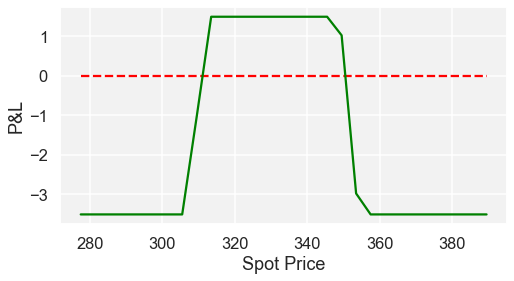

In [45]:
calls = strat.iron_condor(short_delta=.2, plot=True)